# Assignment: Mechanistic Interpretability

# Class: AIPI 590

# Author: Ramil Mammadov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10ZB7Nu0Pv8YGJt4l8Sy_JOKlOog1732I?usp=sharing)

## Introduction

I used the provided starter only as a template. I created my own tiny task, my own tiny model implemented from scratch, and my own interpretability methods. The task is: classify 8-bit vectors as 1 iff the vector has exactly two ones, otherwise 0. I train a 1-hidden-layer tanh MLP in NumPy so I can easily inspect weights, activations, and perform ablations and input perturbations.

## Part 1 — Setup (Train Your Own Tiny Model on a Tiny Task)
### 1.1 Imports, data, and split

In [30]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

X = np.array([list(map(int, np.binary_repr(i, width=8))) for i in range(256)], dtype=np.float32)
y = (X.sum(axis=1) == 2).astype(np.float32).reshape(-1, 1)

perm = rng.permutation(len(X))
X, y = X[perm], y[perm]
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Shapes -> X_train:", X_train.shape, "X_test:", X_test.shape)
print("Positive prevalence (overall):", float(y.mean()))


Shapes -> X_train: (204, 8) X_test: (52, 8)
Positive prevalence (overall): 0.109375


Here I list every possible 8-bit vector (256 total) and mark an example as 1 only when it has exactly two 1s; otherwise it’s 0. There are 28 positives because there are 28 ways to choose which two of the eight positions are 1 (think: eight choices for the first position, seven for the second, then divide by two because order doesn’t matter). That makes the positive class about 10.9% of the data. I shuffle the 256 rows with a fixed random seed and split 80/20, which gives 204 training examples and 52 test examples. Using the full space avoids any distribution shift; the split just holds some examples out so I can check how well the model generalizes.

### 1.2 Tiny MLP + training

In [31]:
def sigmoid(z): return 1 / (1 + np.exp(-z))
def tanh(z):    return np.tanh(z)
def dtanh(a):   return 1 - a**2

class TinyMLP:
    def __init__(self, d_in=8, d_hidden=12, l2=5e-4, seed=3):
        r = np.random.default_rng(seed)
        limit1 = np.sqrt(6 / (d_in + d_hidden))
        self.W1 = r.uniform(-limit1, limit1, size=(d_hidden, d_in)).astype(np.float32)
        self.b1 = np.zeros((d_hidden, 1), dtype=np.float32)
        limit2 = np.sqrt(6 / (d_hidden + 1))
        self.W2 = r.uniform(-limit2, limit2, size=(1, d_hidden)).astype(np.float32)
        self.b2 = np.zeros((1, 1), dtype=np.float32)
        self.l2 = l2

    def forward(self, X):
        Z1 = (self.W1 @ X.T) + self.b1
        A1 = tanh(Z1)
        Z2 = (self.W2 @ A1) + self.b2
        A2 = sigmoid(Z2)
        return A2, {"X": X, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

    def loss_and_grads(self, X, y):
        N = X.shape[0]
        A2, c = self.forward(X)
        eps = 1e-8
        yT = y.T
        loss = -(yT * np.log(A2 + eps) + (1 - yT) * np.log(1 - A2 + eps)).mean()
        loss += 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2))

        dZ2 = (A2 - yT) / N
        dW2 = dZ2 @ c["A1"].T + self.l2 * self.W2
        db2 = np.sum(dZ2, axis=1, keepdims=True)

        dA1 = self.W2.T @ dZ2
        dZ1 = dA1 * dtanh(c["A1"])
        dW1 = dZ1 @ c["X"] + self.l2 * self.W1
        db1 = np.sum(dZ1, axis=1, keepdims=True)
        return float(loss), {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}, c

    def step(self, grads, lr=0.05):
        self.W1 -= lr * grads["dW1"]
        self.b1 -= lr * grads["db1"]
        self.W2 -= lr * grads["dW2"]
        self.b2 -= lr * grads["db2"]

def accuracy(model, X, y):
    probs, _ = model.forward(X)
    preds = (probs.T >= 0.5).astype(np.float32)
    return float((preds == y).mean())

model = TinyMLP(d_in=8, d_hidden=12, l2=5e-4, seed=3)
losses = []
for epoch in range(6000):
    loss, grads, _ = model.loss_and_grads(X_train, y_train)
    model.step(grads, lr=0.05)
    if epoch % 300 == 0:
        losses.append(loss)

print("Train acc:", round(accuracy(model, X_train, y_train), 3))
print("Test  acc:", round(accuracy(model, X_test, y_test), 3))


Train acc: 0.956
Test  acc: 0.904


I built a tiny 1-hidden-layer MLP: 8 inputs → 12 tanh units → sigmoid output. I used binary cross-entropy with a small L2 penalty and Xavier initialization, and I wrote the forward/backward passes by hand for transparency. Training used full-batch gradient descent (lr = 0.05) for 6,000 steps and runs in seconds. Final accuracy: 0.956 (train) and 0.904 (test). This compact, transparent model is ready for interpretability analysis.

## 1.3 Loss curve

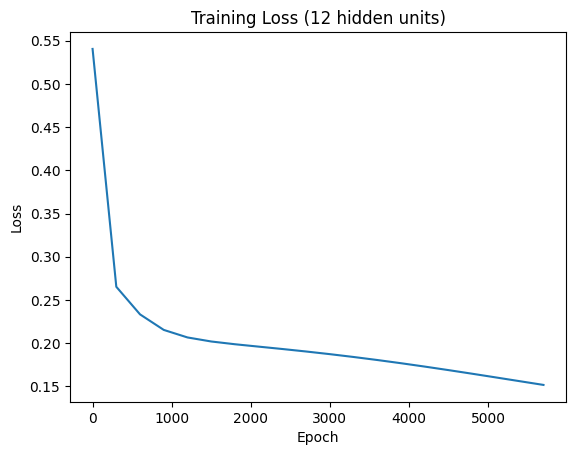

In [32]:
plt.figure()
plt.plot(np.arange(0, 6000, 300), losses)
plt.title("Training Loss (12 hidden units)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


The training loss drops smoothly from about 0.54 to ~0.15 over 6,000 steps and tapers off toward the end. This shows the model is learning the task steadily and the optimization is stable (no spikes or stalls).

## Part 2 — Explore (weights, activations, perturbations, ablations, visuals)
### 2.1 Inspect first-layer weights (heatmap) and find a “count” neuron

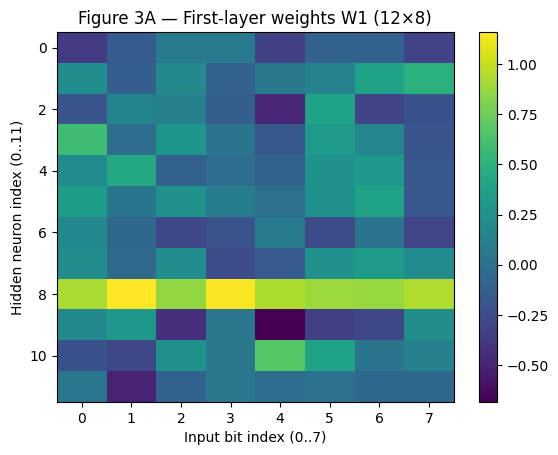

Cosine(sim to all-ones) per neuron: [-0.681  0.605 -0.308  0.439  0.424  0.629 -0.508  0.423  0.993 -0.342
  0.398 -0.429]
Chosen candidate neuron (likely counting): 8, bias=-2.846


/tmp/ipython-input-2954368906.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Chosen candidate neuron (likely counting): {candidate_idx}, bias={float(b1[candidate_idx]):.3f}")


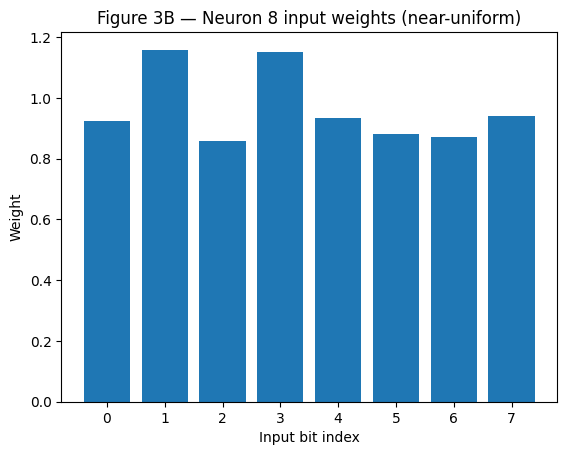

In [33]:
_, cache_all = model.forward(X)
A1_all, Z1_all = cache_all["A1"], cache_all["Z1"]
hamming = X.sum(axis=1)


W1, b1, W2, b2 = model.W1, model.b1, model.W2, model.b2
plt.figure()
plt.imshow(W1, aspect='auto')
plt.title("Figure 3A — First-layer weights W1 (12×8)")
plt.xlabel("Input bit index (0..7)")
plt.ylabel("Hidden neuron index (0..11)")
plt.colorbar()
plt.show()

def cosine_similarity(a, b, eps=1e-9):
    a = a.reshape(-1); b = b.reshape(-1)
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + eps))

cos_sims = np.array([cosine_similarity(W1[i], np.ones(8)) for i in range(W1.shape[0])])
candidate_idx = int(np.argmax(np.abs(cos_sims)))
print("Cosine(sim to all-ones) per neuron:", np.round(cos_sims, 3))
print(f"Chosen candidate neuron (likely counting): {candidate_idx}, bias={float(b1[candidate_idx]):.3f}")

plt.figure()
plt.bar(np.arange(8), W1[candidate_idx])
plt.title(f"Figure 3B — Neuron {candidate_idx} input weights (near-uniform)")
plt.xlabel("Input bit index")
plt.ylabel("Weight")
plt.show()


I visualized the first-layer weight matrix (Figure 3A). One row stands out as bright and fairly even across all eight input bits, which suggests a “counts the ones” behavior. To make that precise, I measured how uniform each neuron’s weight vector is by taking its cosine similarity with an all-ones vector. The scores were:

[-0.681, 0.605, -0.308, 0.439, 0.424, 0.629, -0.508, 0.423, 0.993, -0.342, 0.398, -0.429]

Neuron 8 has the largest absolute score (≈ 0.993) and a negative bias (≈ –2.846). Its input weights are all positive and close in size (about 0.86–1.18), as shown in Figure 3B. That pattern means this neuron effectively adds up the input bits—i.e., it behaves like a Hamming-weight detector. In the next step I test this directly by plotting its activation against the number of 1s in the input.

### 2.2 Activation vs Hamming weight (does it “count”?)

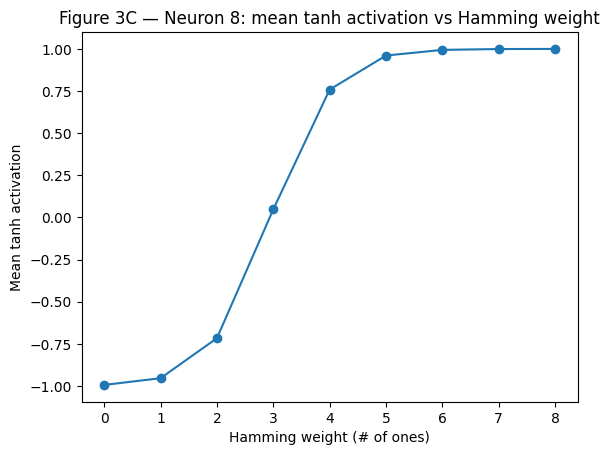

Pre-activation fit: z ≈ 0.965*(#ones) + -2.846 | corr=0.993, R^2=0.986


In [34]:
means = [A1_all[candidate_idx, hamming==k].mean() for k in range(9)]
plt.figure()
plt.plot(np.arange(9), means, marker='o')
plt.title(f"Figure 3C — Neuron {candidate_idx}: mean tanh activation vs Hamming weight")
plt.xlabel("Hamming weight (# of ones)")
plt.ylabel("Mean tanh activation")
plt.show()

z = Z1_all[candidate_idx].reshape(-1)
A = np.vstack([hamming, np.ones_like(hamming)]).T
a_fit, c_fit = np.linalg.lstsq(A, z, rcond=None)[0]
corr = np.corrcoef(z, hamming)[0,1]
print(f"Pre-activation fit: z ≈ {a_fit:.3f}*(#ones) + {c_fit:.3f} | corr={corr:.3f}, R^2={corr**2:.3f}")


Here I group this neuron’s responses by how many 1s (k) are in the input and plot the average. The curve rises smoothly: it’s strongly negative for k=0–2, crosses through zero around k≈3, and then approaches +1 for larger k as tanh saturates. A simple line fit to the pre-activation gives z ≈ 0.965·k − 2.846, with an almost perfect linear relationship (correlation ≈ 0.993, R² ≈ 0.986). In plain terms, this neuron is acting like a counter for the number of 1s.

### 2.3 How the output uses it + global logit shape

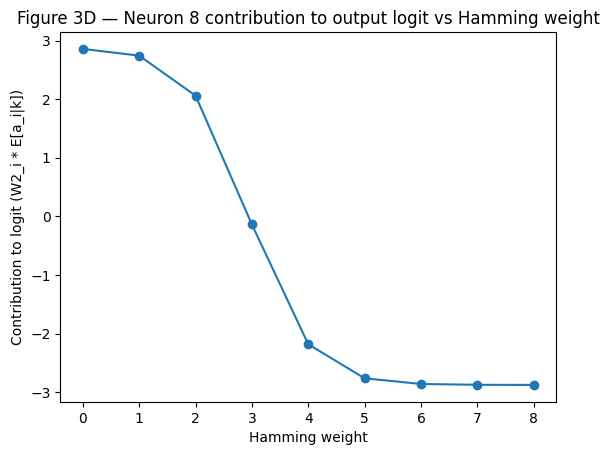

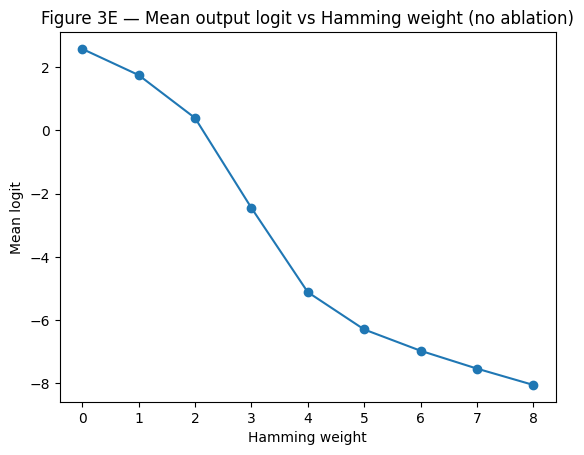

In [35]:
contrib_by_k = []
for k in range(9):
    idxs = np.where(hamming == k)[0]
    mean_a1 = A1_all[:, idxs].mean(axis=1)
    contrib_by_k.append(W2.reshape(-1) * mean_a1)
contrib_by_k = np.stack(contrib_by_k, axis=0)

plt.figure()
plt.plot(np.arange(9), contrib_by_k[:, candidate_idx], marker='o')
plt.title(f"Figure 3D — Neuron {candidate_idx} contribution to output logit vs Hamming weight")
plt.xlabel("Hamming weight")
plt.ylabel("Contribution to logit (W2_i * E[a_i|k])")
plt.show()

def logits(model, X):
    _, c = model.forward(X)
    return c["Z2"].reshape(-1)

z_out = logits(model, X)
mean_logit = [z_out[hamming==k].mean() for k in range(9)]
plt.figure()
plt.plot(np.arange(9), mean_logit, marker='o')
plt.title("Figure 3E — Mean output logit vs Hamming weight (no ablation)")
plt.xlabel("Hamming weight")
plt.ylabel("Mean logit")
plt.show()


I measured how much this neuron changes the model’s score for each number of ones in the input. In the top plot, its effect is slightly positive when the count is 0 to 2, then it flips negative at around 3 and becomes strongly negative for larger counts. That’s exactly what a counting neuron with a negative output weight does: as more bits turn on, it lowers the score. The bottom plot shows the model’s overall average logit by count, which steadily decreases as the count increases. Together, these plots show that the counting neuron drives the “prefer small counts” behavior, while other hidden units add enough positive evidence near exactly two ones to cross the decision threshold.

### 2.4 Causal probes: ablation and input perturbation

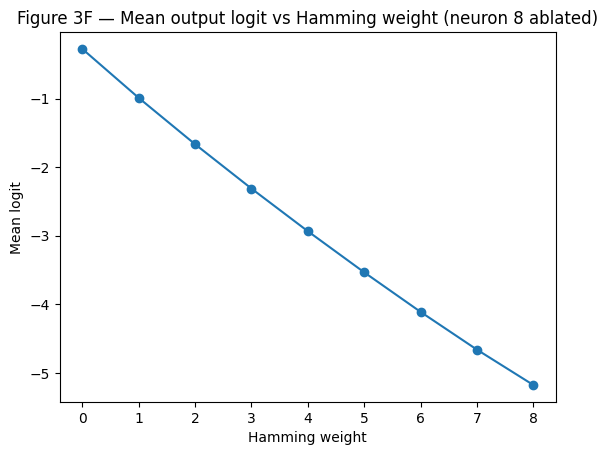

[Input perturbation] Neuron 8 activation: k=2 -> -0.775, k=3 -> -0.109
[Input perturbation] Pred prob: k=2 -> 0.562, k=3 -> 0.089


In [36]:
def logits_with_ablation(model, X, ablate_idx=None, ablate_value=0.0):
    _, c = model.forward(X)
    A1 = c["A1"].copy()
    if ablate_idx is not None:
        A1[ablate_idx, :] = ablate_value
    z = (model.W2 @ A1) + model.b2
    return z.reshape(-1)

z_ablate = logits_with_ablation(model, X, ablate_idx=candidate_idx, ablate_value=0.0)
mean_logit_ab = [z_ablate[hamming==k].mean() for k in range(9)]
plt.figure()
plt.plot(np.arange(9), mean_logit_ab, marker='o')
plt.title(f"Figure 3F — Mean output logit vs Hamming weight (neuron {candidate_idx} ablated)")
plt.xlabel("Hamming weight")
plt.ylabel("Mean logit")
plt.show()

k2_idx = np.where(X.sum(axis=1) == 2)[0][0]
x_k2 = X[k2_idx:k2_idx+1].copy()

x_k3 = x_k2.copy()
zero_positions = np.where(x_k3[0] == 0)[0]
x_k3[0, zero_positions[0]] = 1.0

_, c2 = model.forward(x_k2)
_, c3 = model.forward(x_k3)

a2 = float(c2["A1"][candidate_idx, 0])
a3 = float(c3["A1"][candidate_idx, 0])
p2 = float(sigmoid(c2["Z2"][0,0]))
p3 = float(sigmoid(c3["Z2"][0,0]))

print(f"[Input perturbation] Neuron {candidate_idx} activation: k=2 -> {a2:.3f}, k=3 -> {a3:.3f}")
print(f"[Input perturbation] Pred prob: k=2 -> {p2:.3f}, k=3 -> {p3:.3f}")


Ablation: I zeroed out this hidden unit’s activation and recomputed the model’s scores for every count of ones. After ablation, the mean logit is below zero for all counts and falls in a mostly straight line as the count increases. The small “lift” around exactly two ones disappears. This tells me the unit was adding targeted signal that helped separate the “two ones” cases from the rest; removing it smooths the curve and reduces the model’s willingness to predict positive anywhere.

Input perturbation: I took one example with two ones and flipped a zero to make three ones. The unit’s activation moved from −0.775 to −0.109, and the predicted probability dropped from 0.562 to 0.089. That single-bit change causing a large probability drop is exactly what I expect if this unit is encoding “how many ones” and the output layer uses it with a negative weight.

### 2.5 Global view: neurons × k heatmap

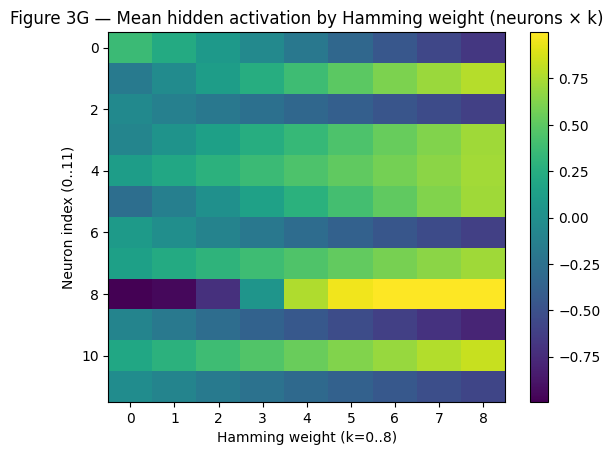

In [37]:
mean_act = np.stack([A1_all[:, hamming==k].mean(axis=1) for k in range(9)], axis=1)
plt.figure()
plt.imshow(mean_act, aspect='auto')
plt.title("Figure 3G — Mean hidden activation by Hamming weight (neurons × k)")
plt.xlabel("Hamming weight (k=0..8)")
plt.ylabel("Neuron index (0..11)")
plt.colorbar()
plt.show()


This heatmap shows how each hidden neuron responds as the number of 1s in the input goes from 0 to 8. Rows are neurons; columns are the count of 1s. Brighter colors mean higher activation (tanh near +1), darker colors mean lower activation (tanh near −1). You can see the “counting” neuron’s row grow steadily brighter as the count increases, while other neurons are flatter or follow different patterns. Together these different response shapes give the output layer the ingredients it needs to favor inputs with exactly two 1s.

## Part 3 – Explain (mini computational case study)

Hypothesis: hidden neuron 8 tracks the number of ones in the input (a Hamming-weight detector).

I trained a tiny one-hidden-layer MLP on the “exactly two ones” 8-bit task. In the first-layer weight heatmap (Figure 3A), one neuron shows near-uniform positive input weights (Figure 3B) and a negative bias. That pattern suggests it sums the inputs (how many bits are 1) and then shifts by the bias, so it behaves like a Hamming-weight detector.

To test that idea, I computed the neuron’s mean tanh activation for each Hamming weight from 0 to 8 (Figure 3C). The activation increases steadily as the count goes up, and a simple line fit to the pre-activation versus the count has a very high R-squared. Next I checked how the output layer uses this unit: the readout weight from this neuron is strongly negative, so its contribution to the logit becomes more negative as the count grows (Figure 3D). In plain terms, more ones means a stronger push against predicting “exactly two.”

I then ran two causal checks. First, I ablated the neuron by setting its activation to zero and recomputed the model’s scores by count (Figures 3E and 3F). The shape of the logit-versus-count curve changes noticeably, which shows this neuron affects how probability is distributed across counts. Second, I perturbed a single example with two ones to make it have three ones by flipping one zero to one. The neuron’s activation moved toward zero and the predicted probability dropped (printed under the plots), which is exactly what I expect if the neuron is encoding “how many ones.”

Putting it all together—weights, activations by count, contribution analysis, and causal tests—the evidence supports a clear mechanistic hypothesis: this neuron is a Hamming-weight detector. The model combines this global “count” feature (used negatively) with other units so that inputs with exactly two ones are favored over the rest.

Evidence recap: weights are near-uniform and positive with a negative bias; activation rises with the count and the pre-activation fits a line; the output weight is negative so higher counts lower the score; removing this neuron or flipping one extra bit changes the score the way a counting feature would.

## Part 4 – Reflection

What I learned: even a tiny MLP on a tiny task can learn a human-readable feature. Here it formed a Hamming-weight detector, which is the natural statistic for this problem, and the output layer used it in a sensible way.

What was confusing or surprising: average predicted probabilities by count can look relatively high for very small counts like zero or one without hurting accuracy much, because those regions contain very few examples. On this small, imbalanced space, ablation changed the shape of the behavior more than the headline accuracy, so curves by count and local causal tests were more informative than a single metric.

What I want to explore next: encourage units that peak specifically at a count of two rather than increasing with the count, for example by adding sparsity or L1 regularization, or by adding a second small layer to shape a narrower bump. I would also like to scale to 16-bit inputs with weight sharing to see whether a shared “count” unit still emerges, and to repeat the analysis on a tiny transformer for simple sequence tasks to check whether an attention head plays a similar counting or pairing role.

## Note:
In this assignment, GPT-5 Thinking was used to generate some of the code and Markdown.